# Adding Delay to the FL technique

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import *

I1 = 0.025
I2 = 0.045
m2 = 1
l1 = 0.3
l2 = 0.33
s2 = 0.16
K = 1/0.06
tau = 0.06

#SHOULDER THEN ELBOW

a1 = I1 + I2 + m2*l2*l2
a2 = m2*l1*s2
a3 = I2

Bdyn = np.array([[0.5,0.025],[0.025,0.5]])


def Compute_Noise(NbreVar,Variance):

    Omega_sens = np.diag(np.concatenate((np.ones(int(NbreVar/2)),np.zeros(int(NbreVar/2)))))
    motor_noise = np.concatenate((np.random.normal(0,np.sqrt(Variance),int(NbreVar/2)),np.zeros(int(NbreVar/2)))).T
    Omega_measure = np.diag(np.ones(NbreVar)*Variance)
    measure_noise = np.concatenate((np.random.normal(0,np.sqrt(Variance),int(NbreVar/2)),np.zeros(int(NbreVar/2)))).T

    return Omega_sens,motor_noise,Omega_measure,measure_noise

def newton(f,Df,epsilon,max_iter,X,Y,x0 = np.array([0.8,1.5])):
    xn = x0
    for n in range(0,max_iter):
        fxn = f(xn,X,Y)
        if abs(np.max(np.abs(fxn))) < epsilon:
            return xn
        Dfxn = Df(xn)
        if np.max(np.abs(Dfxn)) < epsilon:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - np.linalg.inv(Dfxn)@fxn
    print('Exceeded maximum iterations. No solution found.')
    return None

def f(var,X,Y):
    u,v = var
    return np.array([33*np.cos(u+v)+30*np.cos(u)-X,33*np.sin(u+v)+30*np.sin(u)-Y])

def df(var):
    u,v = var
    return np.array([[-33*np.sin(u+v)-30*np.sin(u),-33*np.sin(u+v)],[33*np.cos(u+v)+30*np.cos(u),33*np.cos(u+v)]])



In [29]:
def Feedback_Linearization_with_Delay(Duration = .6,w1 = 1e7,w2 = 1e7,w3 = 1e5,w4 = 1e5,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,Noise_Variance = 1e-6,ForceField = [0,0],ForceFieldSpan = [0,0],newtonfunc = f,newtondfunc = df,Num_iter = 600, ShowJ = True, Delay = .100):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)

    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)
    print(kdelay)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.array([st1,0,0,st2,0,0,obj1,obj2])
    for _ in range(kdelay):
        x0_with_delay = np.concatenate((x0_with_delay,x0))
        

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06
    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.identity(Num_Var*(kdelay+1))*10**-6 

    #Incorporation of delay 

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_xhat = np.zeros((Num_iter,Num_Var))
    array_x_nonlin = np.zeros((Num_iter,Num_Var-2)) 
    array_x = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0_with_delay)
    x_true =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x_nonlin = np.zeros(Num_Var-2)
    x_nonlin[0],x_nonlin[1] = x0[0],x0[3]
    new_x_nonlin = np.copy(x_nonlin)

    #Incorporation of delay 

    #Perform the task
    J = 0
    for k in range(Num_iter-1):

        #Compute the matrices of the system in function of the current state 

        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else 0
        
        _,_,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
        Omega_sens,motor_noise,_,_ = Compute_Noise(Num_Var*(kdelay+1),Noise_Variance)
            
        C = np.array([-xhat[4]*(2*xhat[1]+xhat[4])*a2*np.sin(xhat[3]),xhat[1]*xhat[1]*a2*np.sin(xhat[3])])
        
        Denominator = a3*(a1-a3)-a2*a2*np.cos(xhat[3])*np.cos(xhat[3])
        M = np.array([[a1+2*a2*cos(xhat[3]),a3+a2*cos(xhat[3])],[a3+a2*cos(xhat[3]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*xhat[3])*xhat[4]/(Denominator*Denominator),
                             (a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)],
                            [(a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator),
                            (-2*a2*sin(xhat[3])*xhat[4]*Denominator-(2*a2*cos(xhat[3])+a1)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*xhat[5]*(2*xhat[1]+xhat[4])*sin(xhat[3])-a2*xhat[4]*(2*xhat[2]+xhat[5])*sin(xhat[3])
                         -a2*xhat[4]*xhat[4]*(2*xhat[1]+xhat[4])*cos(xhat[3]),2*xhat[1]*xhat[2]*a2*sin(xhat[3])+xhat[1]*xhat[1]*a2*cos(xhat[3])*xhat[4]])


        # Compute the command through the FL technique

        v = -L[k].reshape(np.flip(B.shape))@xhat
        u = 1/Kfactor*M@(v)-1/Kfactor*M@Minvdot@M@(np.array([xhat[2],xhat[5]]))+M@(np.array([xhat[2],xhat[5]]))+C+Bdyn@np.array([xhat[1],xhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([xhat[2],xhat[5]])
        if ShowJ : J+= u.T@R@u

        # True state of the system
        C = np.array([-x_nonlin[3]*(2*x_nonlin[2]+x_nonlin[3])*a2*np.sin(x_nonlin[1]),x_nonlin[2]*x_nonlin[2]*a2*np.sin(x_nonlin[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(x_nonlin[1])*np.cos(x_nonlin[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(x_nonlin[1])-a3)/Denominator],[(-a2*np.cos(x_nonlin[1])-a3)/Denominator,(2*a2*np.cos(x_nonlin[1])+a1)/Denominator]])
        
        y[k] = (H@x_true).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        #print(y[k]-H@x_internalmodel)
        xhat = A@xhat+B@v + K@(y[k]-H@xhat)
        
        new_x_nonlin[0:2] += dt*x_nonlin[2:4]
        new_x_nonlin[2:4] += dt*(Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C))
        new_x_nonlin[4:6] += dt*Kfactor*(u-x_nonlin[4:6]+F)
        
        
        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x_nonlin[k+1] = new_x_nonlin[:Num_Var-2].flatten()

        acc = (Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C))
        oldxtrue = np.copy(x_true)
        x_true = np.concatenate((np.array([new_x_nonlin[0],new_x_nonlin[2],acc[0],new_x_nonlin[1],new_x_nonlin[3],acc[1],x_true[6],x_true[7]]),x_true[:-Num_Var]))
        for k in range(Num_Var):
            if x_true[Num_Var+k] != oldxtrue[k] : print("Error")
        array_x[k+1] = x_true[:Num_Var].flatten()
        
        

        #Perform Iteration 
        
        
        x_nonlin = np.copy(new_x_nonlin)
        
        #print(array_x_true[k-1,2],((array_x_true[k]-array_x_true[k-1])/dt)[1])   

    if ShowJ : 
        J+= x_true.T@Q@x_true
        print("Total cost of FL: "+str(J)[:7])
    #Change of coordinates from angular to cartesian 
    
    x_nonlin = array_x_nonlin.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[1])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[1])*33+np.sin(x_nonlin[0])*30

    #x_nonlin = array_x.T[:,1:][:,::1]
    #X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    #Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    x_nonlin = array_xhat
    X2 = np.cos(x_nonlin[:,0]+x_nonlin[:,3])*33+np.cos(x_nonlin[:,0])*30
    Y2 = np.sin(x_nonlin[:,0]+x_nonlin[:,3])*33+np.sin(x_nonlin[:,0])*30

    #Plotting
    color1 = plt.get_cmap('viridis')(kdelay*4 / Num_iter)

# Generate an array of 80 colors from the colormap


    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = color1,label = "True movement with "+str(int(kdelay*dt*1000))+ " \n miliseconds delay",linewidth = .8)
        if kdelay != 0 : 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = .3)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "black")
        
    #print("Optimum values " + str(J1)[:8]+" and "+str(J2)[:8])

    
    return X,Y




1


Text(0.5, 1.0, '800 ms Movement')

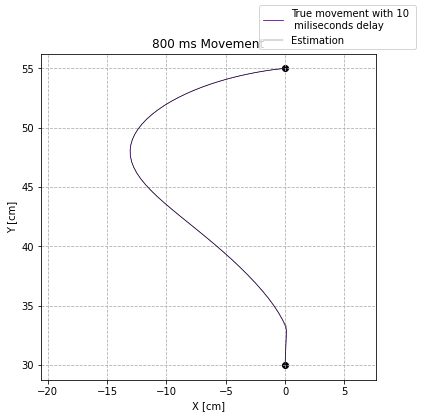

In [28]:
fig,ax = plt.subplots(figsize = (6,6))
for delay in [.01]:
    Feedback_Linearization_with_Delay(w1 = 1e8,w2 = 1e6,Duration = .8,Noise_Variance=1e-6,Num_iter=80,Delay=delay,ForceField=[40,0],ForceFieldSpan=[.2,.22],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.title("800 ms Movement")

0
[ 0.40606785  2.15316056  0.          0.          0.04655709 -0.03148514]
[ 0.40606785  2.15316056  0.00503082 -0.0090761   0.09240295 -0.06535393]
[ 0.40611816  2.1530698   0.01476832 -0.02664375  0.13127576 -0.09937743]
[ 0.40626584  2.15280337  0.02830425 -0.05144714  0.17162287 -0.13442078]
[ 0.40654889  2.15228889  0.04553106 -0.08289236  0.21204677 -0.17108059]
[ 0.4070042   2.15145997  0.06625786 -0.12055461  0.25158964 -0.20935419]
[ 0.40766677  2.15025443  0.09022754 -0.16403386  0.29047726 -0.2490033 ]
[ 0.40856905  2.14861409  0.11721093 -0.21293893  0.32866827 -0.28979379]
[ 0.40974116  2.1464847   0.1469831  -0.26687819  0.36605626 -0.3314925 ]
[ 0.41121099  2.14381592  0.17931776 -0.32545764  0.40258192 -0.3738626 ]
[ 0.41300417  2.14056134  0.21399119 -0.38828188  0.43818372 -0.41667217]
[ 0.41514408  2.13667852  0.25078212 -0.45495495  0.47279613 -0.45969601]
[ 0.4176519   2.13212897  0.2894715  -0.52508131  0.50635538 -0.50271618]
[ 0.42054662  2.12687816  0.32984271

Text(0.5, 1.0, '800 ms Movement')

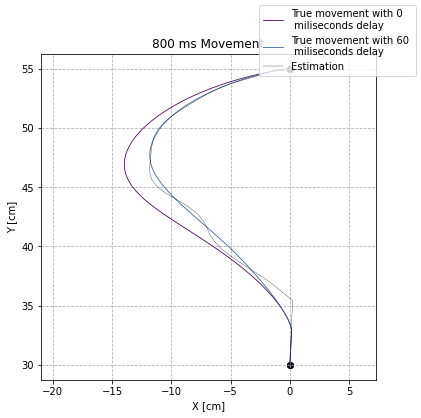

In [14]:
fig,ax = plt.subplots(figsize = (6,6))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e8,w2 = 1e6,Duration = .8,Noise_Variance=1e-6,Num_iter=80,Delay=delay,ForceField=[40,0],ForceFieldSpan=[.2,.22],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.title("800 ms Movement")

0
6


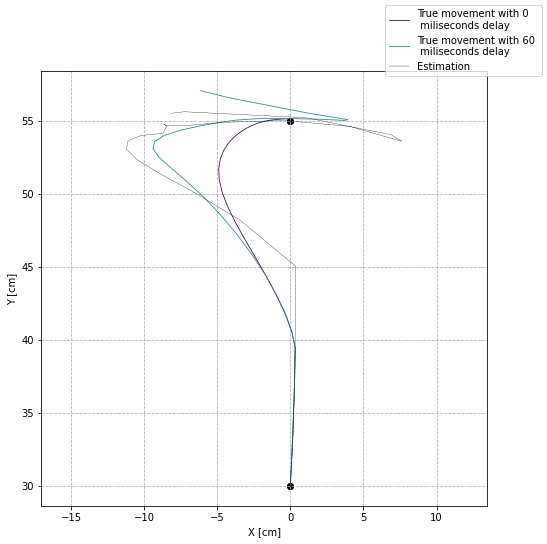

In [8]:
fig,ax = plt.subplots(figsize = (8,8))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e8,w2 = 1e8,Duration = .5,Noise_Variance=1e-16,Num_iter=50,Delay=delay,ForceField=[80,0],ForceFieldSpan=[.2,.22],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)

0
6


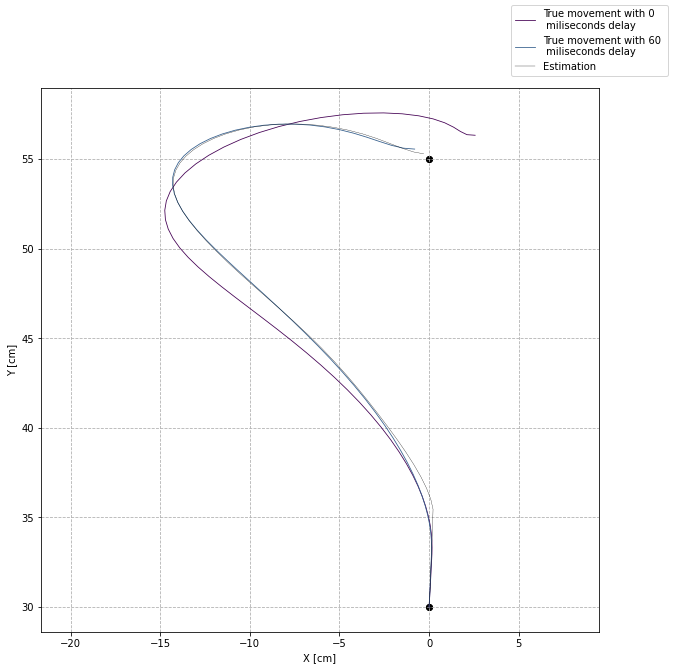

In [5]:
fig,ax = plt.subplots(figsize = (10,10))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e9,w2 = 1e6,Duration = .8,Noise_Variance=1e-6,Num_iter=80,Delay=delay,ForceField=[3,0],ForceFieldSpan=[.2,5],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)

0
6


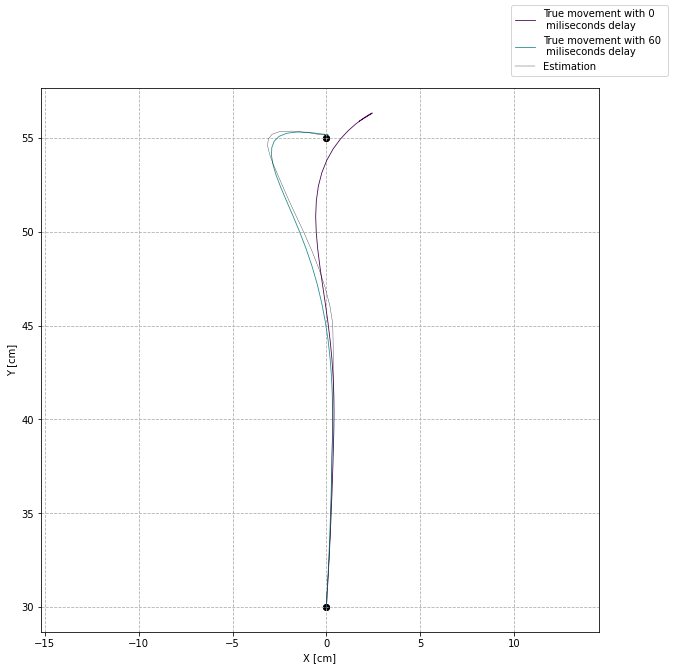

In [6]:
fig,ax = plt.subplots(figsize = (10,10))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e9,w2 = 1e9,Duration = .5,Noise_Variance=1e-64,Num_iter=50,Delay=delay,ForceField=[3,0],ForceFieldSpan=[.2,5],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)